# Report - Mobile robotics project

*By Pierre Chassagne 289475, Thomas Peeters 288239, Titouan Renard 272257 and Gabriel Vallat 273730*

### This report requires ipywidgets :

In [1]:
!pip install ipywidgets

In [2]:
from IPython.display import Video

Video("videos/4.m4v",width=800)

In this project, the aim was to control a mobile robot in a designed environnement, containing both static obstacles that needed to be detect by a vision module and moving obstacles that needed to be avoided in a reactive way. 
In our case, we chose the following environment:
A thymio and some black obstacles are placed in a one meter by one meter white square, delimited by colorfull corners (from top left to bottom right: green, yellow, red, and blue). 
The robot is covered by an assymetric magenta shape, and the aim is a cyan star. 
The new obstacles are detected by the proximity sensor, and can be of any shape and color.

In [3]:
%matplotlib inline
import cv2 #read video and images
import numpy as np
from skimage import measure,exposure
from scipy import linalg, ndimage
import math
import sys
from matplotlib import pyplot as plt
from Functions import Robot 
from Functions import Utilities as u
from Functions import Global as g
from ipywidgets import interact, interactive, fixed, interact_manual
from Functions import Vision as v
from Functions import Visualization as viz
vz = viz.Visualization()

## Recording Data from the Robot

![FSMRobot.jpg](sample_pictures/setting_labeld.png)

One of the more notable design choice that was made as we went into this project was the implementation of a data recording functionality on the robot. Our main class saves some of the most important variables required for the robot's control 10x per second as the program is running, and we can later review the using a Visualization class. Not only was this a great debug tool and a nice way for us to better understand the behavior of the robot but it also provides us with nice examples that we use in this report. 

The robot data is saved in .pkl files (using the pickle module that allow to directly dump python object to files). We can the load an review the data using methods implemented in the Visualization class.

The main parameters that are saved are the following:
* position as computed by the vision and as computed by the filtering
* map, as seen by the robot
* global path
* time
* state of the robot's state machine
* motor speed values
* robot's proximity sensor measured values
* robot controller variables
* goal position, that the robot needs to navigae to

At the end of this report, we show an interactive viewer for a series of runs.

#### Example of plotting of the robot's motor speed for both motors using the Visualization module after a successful run :

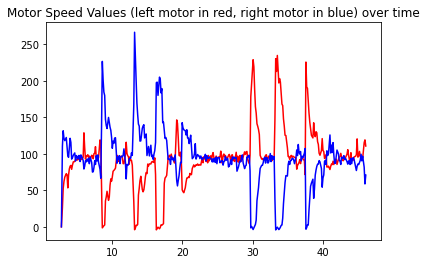

In [4]:
data = vz.loadData('runs/run_3.pkl')
vz.plotMotors(data)

## Vision
For the vision part of this project, a class was created to compute and store all of the following elements:
* The geometric transform applied to the image
* The preprocessing parameters
* The preprocessed and transformed image that will be used 
* The positions and shapes of the obstacles
* The position of the robot, its orientation and its direction
* The position of the aim
The following section will detail how these were implemented.

### Preprocessing
The first step in any vision task is to preprocess the image. In our case, we wanted a fonction that was fast and that could be used on several different cameras, as we all used different phones to film the setup. As the white map could be placed on several different background and with several different illuminations, a semi-automatic control of the parameter proved to be usefull. The following code shows how we preprocessed the image, including the following steps:
* Resize the image: This allows us to use several different cameras, and to limit the time all the other image processing step takes by limiting the resolution to a resonnable amount
* Rescaling intensity: This steps allows to scale the intensity of the image between two given value. For example, if the image is rescaled between 10 and 100, this means that any intensity below 10 will be set to 0, any intensity above 100 will be set to 255, and all the values in between will be stretched.
* The image is then converted from BGR to HSV, as it is way better for color filtering
* The image is converted to UMat, to allow GPU calculation



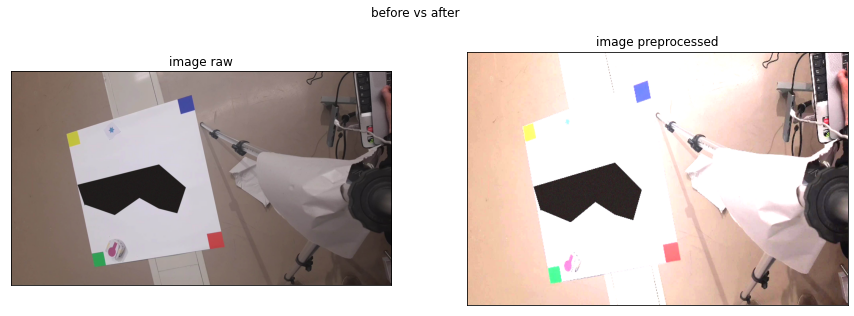

In [5]:
img = cv2.imread('sample_pictures/test_border.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgprep = v.preprocess(img,(10,128))
imgprep_rgb = cv2.cvtColor(imgprep.get(), cv2.COLOR_HSV2RGB)


fig, (raw, prep) = plt.subplots(1, 2)
fig.set_size_inches(15,5)
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.suptitle('before vs after')

raw.imshow(img_rgb)
raw.set_title('image raw')


prep.imshow(imgprep_rgb)
prep.set_title('image preprocessed')
plt.show()

Once the image is preprocessed, each corner is selected using a colorfilter and a morphological opening to remove noise. The centroid of the resulting image is then used to get the center of each corner.
A possibility to use different cameras, changing a bit the hue value of the real color, was implemented (the camera variable in the following code). 
Note that when the centroid is still noisy, or if no pixel pass the filter, a flag is set to tell that the corner was not correctly detected.

invalid centroid:noise
RED ERROR


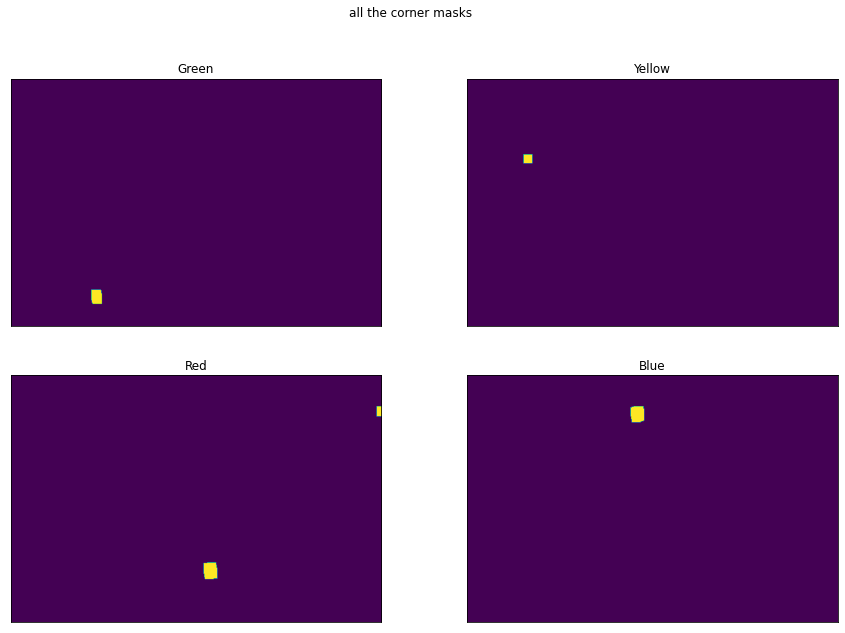

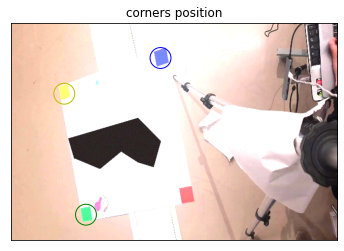

In [6]:
invalid = False
camera = "ANDROID FLASK"
filr = v.colorfilter("RED",camera)
filg = v.colorfilter("GREEN",camera)
filb = v.colorfilter("BLUE",camera)
fily = v.colorfilter("YELLOW",camera)

maskg= filg.get_mask(imgprep)
TL,fg = v.getCentroid(maskg)
if fg:
    print("GREEN ERROR")
    invalid = True

masky= fily.get_mask(imgprep)
TR,fy = v.getCentroid(masky)
if fy:
    print("YELLOW ERROR")
    invalid = True

maskr= filr.get_mask(imgprep)
BL,fr = v.getCentroid(maskr)
if fr:
    print("RED ERROR")
    invalid = True



maskb= filb.get_mask(imgprep)
BR,fb = v.getCentroid(maskb)
if fb:
    print("BLUE ERROR")
    invalid = True
    
fig, axs = plt.subplots(2,2)
fig.set_size_inches(15,10)
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.suptitle('all the corner masks')

axs[0,0].imshow(maskg.get())
axs[0,0].set_title('Green')

axs[0,1].imshow(masky.get())
axs[0,1].set_title('Yellow')

axs[1,0].imshow(maskr.get())
axs[1,0].set_title('Red')

axs[1,1].imshow(maskb.get())
axs[1,1].set_title('Blue')

fig,ax = plt.subplots()
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
ax.imshow(imgprep_rgb)
ax.set_title('corners position')
if  not fg:
    circle = plt.Circle(TL, 20, color='g',fill=False)
    ax.add_artist(circle)
if  not fy:
    circle = plt.Circle(TR, 20, color='y',fill=False)
    ax.add_artist(circle)

if  not fb:
    circle = plt.Circle(BR, 20, color='b',fill=False)
    ax.add_artist(circle)
    
if  not fr:
    circle = plt.Circle(BL, 20, color='r',fill=False)
    ax.add_artist(circle)
plt.show()


### Setting the parameters
As said before, the background and luminosity can change. To avoid any problem, the min and max luminosity can be changed at the begining of the program by activating a flag, otherwise, default values are calulated as being the 10th adn 90th percentiles of the image.

In [7]:
valext = np.percentile(img, (10, 90)).astype(int) #default value
def demo(valmin=valext[0],valmax=valext[1]):
    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(15,6)
    [ax.get_xaxis().set_visible(False) for ax in fig.axes]
    [ax.get_yaxis().set_visible(False) for ax in fig.axes]
    imgprep = v.preprocess(img,(valmin,valmax))
    img_disp = cv2.cvtColor(imgprep,cv2.COLOR_HSV2RGB)
    axs[0].imshow(img_disp.get())
    axs[0].set_title('preprocessed image')

    maskg = v.colorfilter("GREEN",camera = "ANDROID FLASK")
    masky = v.colorfilter("YELLOW",camera = "ANDROID FLASK")
    maskr = v.colorfilter("RED",camera = "ANDROID FLASK")
    maskb = v.colorfilter("BLUE",camera = "ANDROID FLASK")
    maskrobot = v.colorfilter("ROBOT",camera = "ANDROID FLASK")
    maskfinish = v.colorfilter("FINISH",camera = "ANDROID FLASK")
    maskobst = v.colorfilter("BLACK",camera = "ANDROID FLASK")
    masktot = maskg.get_mask(imgprep)
    masktot = cv2.bitwise_or(masktot,masky.get_mask(imgprep))
    masktot = cv2.bitwise_or(masktot,maskr.get_mask(imgprep))
    masktot = cv2.bitwise_or(masktot,maskb.get_mask(imgprep))
    masktot = cv2.bitwise_or(masktot,maskrobot.get_mask(imgprep))
    masktot = cv2.bitwise_or(masktot,maskfinish.get_mask(imgprep))
    
    maskobst = maskobst.get_mask(imgprep)
    
    axs[1].imshow(maskobst.get())
    axs[1].set_title("obstacles masks")
    
    img_mask = cv2.bitwise_and(img_disp,img_disp, mask= masktot.get().astype("uint8"))
    axs[2].imshow(img_mask.get().astype(int))
    axs[2].set_title("color masks") 
    plt.show()
w = interactive(demo,valmin=(0,255),valmax=(0,255))
display(w)

interactive(children=(IntSlider(value=48, description='valmin', max=255), IntSlider(value=208, description='va…

With some backgrounds, even a perfect preprocessing cannot differentiate the corner from some item. To handle such cases, a flag can be set in the initialisation to select the corners using a custom watershed algorithme, overwriting the invalid corners detected with the color filter

invalid centroid:noise
RED ERROR
CLic on ROI, then press y if the centroid is correct, n to reset


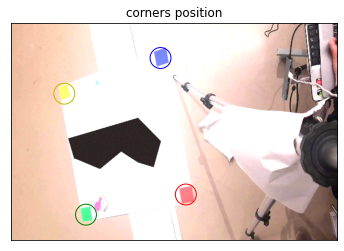

In [14]:
#same code as before, but this time allows manual selection
setmanually = True
invalid = False

filr = v.colorfilter("RED",camera)
filg = v.colorfilter("GREEN",camera)
filb = v.colorfilter("BLUE",camera)
fily = v.colorfilter("YELLOW",camera)


maskg= filg.get_mask(imgprep)
TL,fg = v.getCentroid(maskg)
if fg:
    print("GREEN ERROR")
    if setmanually:
        TL = v.manually_get_centroid(imgprep, preprocessed=True)
        fg = False

masky= fily.get_mask(imgprep)
TR,fy = v.getCentroid(masky)
if fy:
    print("YELLOW ERROR")
    if setmanually:
        TR = v.manually_get_centroid(imgprep, preprocessed=True)
        fy = False

maskr= filr.get_mask(imgprep)
BL,fr = v.getCentroid(maskr)
if fr:
    print("RED ERROR")
    if setmanually:
        BL = v.manually_get_centroid(imgprep, preprocessed=True)
        fr = False

maskb= filb.get_mask(imgprep)
BR,fb = v.getCentroid(maskb)
if fb:
    print("BLUE ERROR")
    if setmanually:
        BR = v.manually_get_centroid(imgprep, preprocessed=True)
        fb = False
        
        
#ploting everything
fig,ax = plt.subplots()
ax.imshow(imgprep_rgb)
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
ax.set_title('corners position')
if  not fg:
    circle = plt.Circle(TL, 20, color='g',fill=False)
    ax.add_artist(circle)
if  not fy:
    circle = plt.Circle(TR, 20, color='y',fill=False)
    ax.add_artist(circle)

if  not fb:
    circle = plt.Circle(BR, 20, color='b',fill=False)
    ax.add_artist(circle)
    
if  not fr:
    circle = plt.Circle(BL, 20, color='r',fill=False)
    ax.add_artist(circle)
plt.show()

Once all the corners are set, the projection matrix is calculated and projection matrix is stored for future use.
The resulting image is set to a 500 to 500 size, containing only the map. In the case where the corners are found to be invalid, a previous transform (given in the argument) is returned. This allows the proje

In [15]:
prevtrans = np.identity(3)

invalid centroid:noise
RED ERROR
CLic on ROI, then press y if the centroid is correct, n to reset


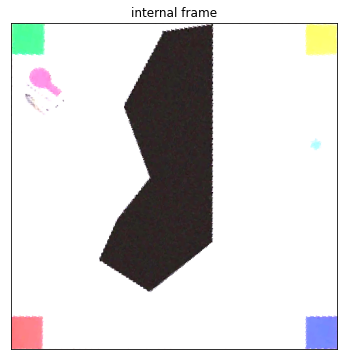

In [17]:
transform, invalid = v.getTransformimage(img,camera,prevtrans,tuple(valext), setmanually = True)
if not invalid:
    imgreal = cv2.warpPerspective(imgprep, transform, (500,500),borderMode=cv2.BORDER_REFLECT_101, flags = cv2.INTER_NEAREST)
    imgreal_rgb = cv2.cvtColor(imgreal,cv2.COLOR_HSV2RGB).get()
    prevtrans = transform
    fig,ax = plt.subplots()
    fig.set_size_inches(6,6)
    ax.imshow(imgreal_rgb)
    [ax.get_xaxis().set_visible(False) for ax in fig.axes]
    [ax.get_yaxis().set_visible(False) for ax in fig.axes]
    ax.set_title('internal frame')
    plt.show()
else:
    print("invalid transform")

### Obstacles 
Once the map is processed and stored, the obstacles are computed in the following steps:
* A color filter is applied on the map, selecting black pixels
* The obstacles are morphologically dilated 30 times by a 3x3 cross, increasing their size so the side of the robot does not touche them when getting too close
* A next dilation, this time by a 30x30 square, improve the shape of the obstacles when they are on the side of the map
* The obtained shapes are the approximated by polygons, using a margin of 15 pixels
The obstacles are then stored in a list and send to the global path calculation


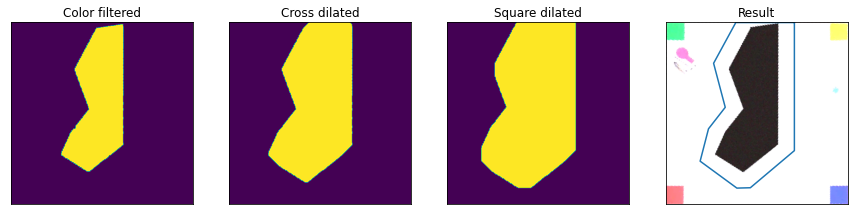

In [18]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(15,5)
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
ax[0].set_title("Color filtered")
ax[1].set_title("Cross dilated")
ax[2].set_title("Square dilated")
ax[3].set_title("Result")


#addapted of v.createMap
border_size =30
filter_poly = v.colorfilter("BLACK",camera)
maskpoly = filter_poly.get_mask(imgreal)
ax[0].imshow(maskpoly.get())

# cv2.imshow("mask poly", maskpoly)
margin = cv2.dilate(maskpoly,cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))\
                    ,iterations = 30,borderType =cv2.BORDER_CONSTANT,borderValue = 0)
ax[1].imshow(margin.get())
margin = cv2.dilate(margin,cv2.getStructuringElement(cv2.MORPH_RECT, (border_size,border_size))
                    ,iterations = 1,borderType = cv2.BORDER_CONSTANT,borderValue = 0)
ax[2].imshow(margin.get())
polyprojbin = margin.get().astype(np.uint8)
contours, ret = cv2.findContours(polyprojbin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
polygons = []
ax[3].imshow(imgreal_rgb)
for c in contours:
    polygon    =  cv2.approxPolyDP(c, 15, True)
    polygon = np.append(polygon,np.reshape(polygon[0,:,:],(1,1,2)),axis = 0)
    ax[3].plot(polygon[:,0,0],polygon[:,0,1])

### Robot Position
The final step in the vision module is to find the robot and the aim. The aim is simply found by using the same algorythm as the corners, but the robot necessitates more calculations to find both the angle and the direction.
Moreover, as we wanted to keep a high framerate, we could not simply remove the noise by doing an opening on the whole image. This is then how we detected the pose of the robot:
* First, the image is color filtered, but without doing any opening
* An estimation of the robot posisition is then computed using the first order moment, and the image is then segmented around it (resulting in a 80x80 image, much faster to process)
* This small image is opened, removing noise (which highly impact the higher order moments)
* The centroid, as well as the central moments of the second and third orders are computed on the segmented image
* The angle is extracted from the second moments
* The segmented image is rotated by this angle, aligning the robot on the x-axis
* The sign of the moment 3,0 gives the orientation of the robot
* The first estimation of the centroid is corrected with the value found on the segmented image<br><br>

As always, a flag is sent if the result is not valid, allowing the kalman filter to discard it if needed

phi(without correction): 39.80844437601322
phi (with correction):39.80844437601321


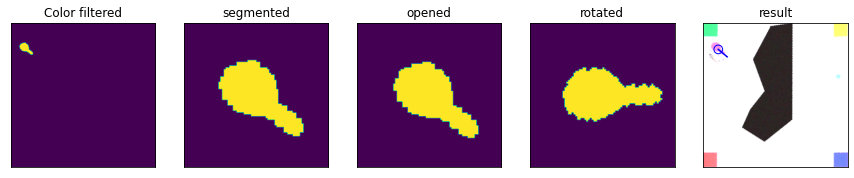

In [19]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(15,5)
[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
ax[0].set_title("Color filtered")
ax[1].set_title("segmented")
ax[2].set_title("opened")
ax[3].set_title("rotated")
ax[4].set_title("result")

#adapted from v.getRobotPos
filter_robot = v.colorfilter("ROBOT",camera)
imageBin = filter_robot.get_mask(imgreal)
imageBin = imageBin.get().astype(np.uint8)
ax[0].imshow(imageBin)
valid = True
moments = measure.moments(imageBin, order = 1)
if moments[0,0]>800: 
    centroid = np.array([moments[0,1]/moments[0,0], moments[1,0]/moments[0,0]])

    #now that we have the center, we segment to cut the  and reduce the computation time
    segsize = 40
    imgsegmented = imageBin[int(centroid[1]-segsize):int(centroid[1]+segsize)\
                            ,int(centroid[0]-segsize):int(centroid[0]+segsize)]
    ax[1].imshow(imgsegmented)
    imgclean = cv2.morphologyEx(imgsegmented, cv2.MORPH_OPEN, np.ones((4,4)).astype("uint8"))
    ax[2].imshow(imgclean)
    momentseg = measure.moments(imgclean, order = 2)
    if momentseg[0,0]<50:
        print("centroid error: too dispersed")
    centroidseg = np.array([momentseg[0,1]/momentseg[0,0], momentseg[1,0]/momentseg[0,0]])
    varx = momentseg[0,2]/momentseg[0,0]-centroidseg[0]**2
    vary = momentseg[2,0]/momentseg[0,0]-centroidseg[1]**2
    varxy = momentseg[1,1]/momentseg[0,0]-centroidseg[0]*centroidseg[1]
    #check the variance of the image segmented
    if max(varx,vary)>2*imageBin.size**0.5:
        if verbose:
            print("invalide coord:noise")
    #get the angle
    if abs(varx-vary)<0.0001:
        phi = math.pi/4
    else:
        phi = math.atan(2*varxy/(varx-vary))/2 +(varx<vary)*math.pi/2
    
    print("phi(without correction): "+str(phi*180/math.pi))

    #rotate the segmented image on the axe x to check the direction by using the 
    #assymetry of the shape
    imgrot = ndimage.rotate(imgsegmented,phi*180/math.pi, reshape = False)
    ax[3].imshow(imgrot)
    newmoments = measure.moments(imgrot)
    cm03 = newmoments[0,3] \
           -3*newmoments[0,2]*newmoments[0,1]/newmoments[0,0]\
           +2*newmoments[0,1]**3/newmoments[0,0]**2
    if cm03 < 0:
        phi+=math.pi

    phi = (phi+math.pi)%(2*math.pi)-math.pi

    print("phi (with correction):"+str(phi*180/math.pi))
    centroidcor = centroid+centroidseg-[segsize,segsize]
    pos = np.append(centroidcor,phi)
    ax[4].imshow(imgreal_rgb)
    ax[4].plot([pos[0],pos[0]+math.cos(pos[2])*40],[pos[1],pos[1]+math.sin(pos[2])*40],color = 'b')
    circle = plt.Circle(pos[0:2], 15, color='b',fill=False)
    ax[4].add_artist(circle)
else:
    print("invalid coord: no or not enough pixel")
        

In [20]:
%matplotlib inline
import cv2 #read video and images
import numpy as np
from skimage import measure,exposure
from scipy import linalg, ndimage
import math
import sys
from matplotlib import pyplot as plt
from Functions import Utilities as u
from Functions import Global as g
from ipywidgets import interact, interactive, fixed, interact_manual
from Functions import Vision as v
import Functions.Visualization as viz
vz = viz.Visualization()

## Path planning
The path planning module is takes as input the obstacles computed by the vision module and returns a shortest path through the obstacles, it performs the following operations to compute the path, essentially the path planning process can be subdivided into two main steps :

* From the obstacles mapped by the vision a visibility graph is computed, this is a weighted graph where nodes represent valid positions, the edges represent valid paths between valid positions and the weights represent the lenght of the paths
* Dikjstra's algorithm is in turn run on the visibility graph and returns a shortest path, this path is then forwarded to the robot controler

#### Example path planning problem, described by a map (a set of 2d polygons) and start and finish points (2d points)

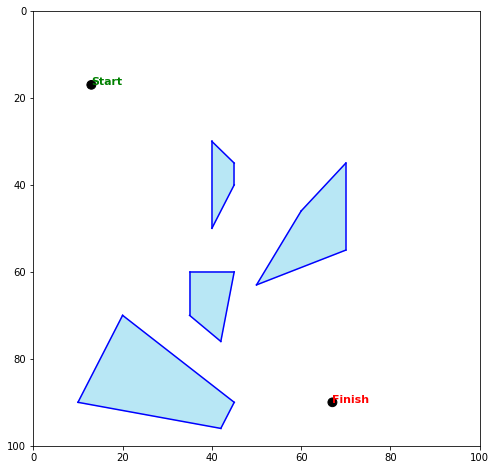

In [21]:
def complexMap():
        polyA = [(40.,30.),
                 (40.,50.),
                 (45.,40.),
                 (45.,35.)]

        polyB = [(70.,35.),
                 (60.,46.),
                 (50.,63.),
                 (70.,55.)]

        polyC = [(35.,60.),
                 (35.,70.),
                 (42.,76.),
                 (45.,60.)]

        polyD = [(20.,70.),
                 (10.,90.),
                 (42.,96.),
                 (45.,90.)]

        return [polyA,polyB,polyC,polyD]
    
start = (13.,17.)
goal = (67.,90.)
    
ut = u.Utilities()
ut.mapPlot(map = complexMap(),start=start, finish=goal)

### Visibility Graph Construction

We construct a visibility graph according to the following algorithm :

```

Let Q be an array containg the start vertex
Let U be an array containing of all vertices of polygons on the map and the goal vertex
Let E be an empty array of edges
Let V be an empty array of vertices

while Q not empty:
    pop h from Q (put the head of Q into h and remove it from Q)
    add h to V
    let N be the set of vertices in U that are neighbors of h
    for all vertices n in N:
        if it is possible to trace a segment from h to n without intersecting a polygon's border
            remove n from U and add it to Q
            append the edge (h,n) to E
            
return the G = (V,E)

```

This is implemented in the Global.py module, as the code is quite long and is basically the entire Global.py module, we chose not to show it in it's entirety in this report but simply to import the module and demonstrate the different steps by calling the relevant functions from the notebook.

#### Example visibility graph, as computed by the algorithm above (implementation from the Global.py module)

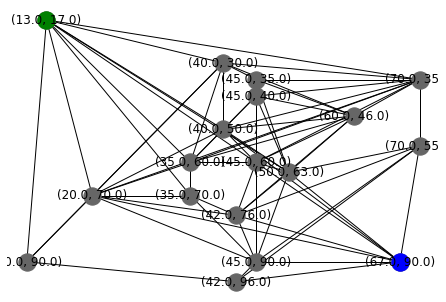

In [22]:
gl = g.Global(complexMap(), start, goal, margin = 3)
graph = gl.computeGraph()
gl.netPlot(graph,start = start, finish = goal)

## Computing the shortest path

The visibility graph is a weighted graph that represents the topology of the map, the weight of the edges are given by the distance between the nodes in space. Computing the physical shortest path for the robot can therefore be performed by finding a shortest path on the weighted visibility graph. This can be performed using Dikjstra's algorithm, if the graph was bigger it may have made sense to use A* to ensure good performance but the graphs here are small enough that it is of no significance.

The computation of the shortest path is implemented in the Global.py module using the networkx library for python. An example of shortest path can be seen below (shortest path plotted in red on the visibility graph).

#### Example Path in graph, as computed by Dikjstra's algorithm, followed by representation of said path on the original map

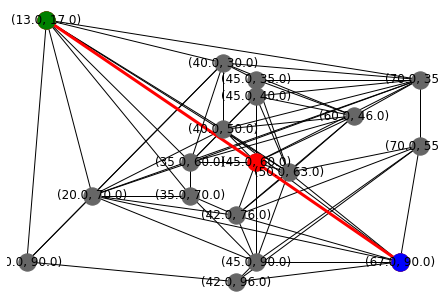

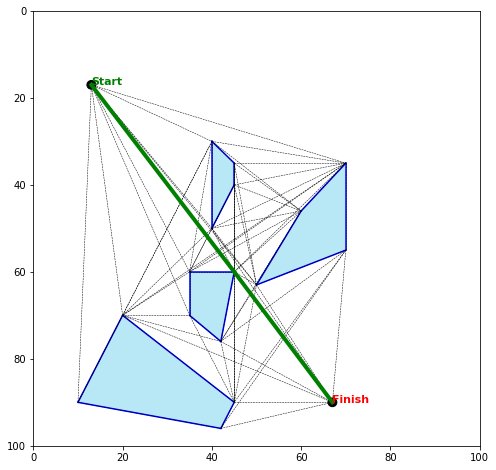

[(13.0, 17.0), (45.0, 60.0), (67.0, 90.0)]

In [23]:
path = gl.returnPath(complexMap(),start,goal)
gl.netPlot(graph,start = start, finish = goal, path = path)
gl.plotPath(plotMap=True)

### Interactive Path Planning playground

Example of shortest path computation on a map loaded from a real run of the robot using the data recording module

In [24]:
def demo(sx=26.,sy=13.,gx=60.,gy=85.):
    data = vz.loadData('runs/run_6.pkl')
    tMap = data[-1]['map']
    gl = g.Global(tMap, (sx,sy), (gx,gy))
    path = gl.returnPath(tMap, (sx,sy), (gx,gy))
    if path is not False:
        gl.plotPath(plotMap=True)
    else:
        print("no path found")
        vz.mapPlot(map=tMap,start=(sx,sy), finish=(gx,gy) )
    
w = interactive(demo,sx=(0.,100.),sy=(0.,100.),gx=(0.,100.),gy=(0.,100.))
display(w)

interactive(children=(FloatSlider(value=26.0, description='sx'), FloatSlider(value=13.0, description='sy'), Fl…

## Kalman Filtering

### Motivation for using Kalman filtering

One of the main challenge of this project is to use filtering in order to estimate the exact position of the robot over time. However there are only few sensors at our disposal to do so and there isn't a direct mapping between them and the values of the states used for the control of the robot. There are three sensors at our disposal : 
1. Motor speed sensors : they give the current value of the wheels' speed. They have a large bandwith but because of their limited precision the integration of the speed results in position drift over time. They also are quite sensitive to environmental noise.
2. Accelerometer : It gives the current value of the acceleration, as for the Motor speed sensors even if it has a large bandwith its limmited precision results in speed and position drifts.
3. The camera : By using pattern recognition the camera can be used as a position sensor, however due to projection errors and noise it has a low precision on the position measurements, especially regarding the measurements of the angle theta of the robot. 

Since the control of the robot relies only on its speed, it was decided to only use the **motor speed sensors** and the **camera** to get the measurements of the robot states.

### Brief review of how the Kalman Filter works

<center><img src = "sample_pictures/Kalman.png" width = "500"/>

As shown on the figure above the Kalman Filter operate in two steps. The first one is the prediction step : in our case the predicted state is computed by the controler and directly given to the Kalman Filter. The second step is the update step. The equations that governs the Filter are the following : 

#### State Space model

<span style="color: #2980B9 ;">
<blockquote>
$x_k = A_kX_{k-1} + B_ku_k + w_k$

* $A_k$ : is the state transition model
* $B_k$ : is the control_input model
* $w_k$ : is the process noise which is assumed to follow a multivariate normal distribution of mean **0** and covariance $Q_k : w_k\sim N(0,Q_k)$
</blockquote>
</span>
    
#### Measurements model

<span style="color: #2980B9 ;">
<blockquote>
$z_k = H_kx_k + v_k$

* $H_k$ : maps the measure to the state of the model
* $v_k$ : is the observation noise which is assumed to follow a multivariate normal distribution of mean **0** and covariance $R_k : w_k\sim N(0,R_k)$
</blockquote>
</span>

#### Prediction step

<span style="color: #2980B9 ;">
<blockquote>
$\hat x_{k|k-1} = A_k\hat x_{k-1|k-1} + B_ku_k$ (Predicted (a priori) state estimate)
<br>    
$P_{k|k-1} = A_kP_{k-1|k-1}A_k^T + Q_k$ (Predicted (a priori) estimate covariance)
</blockquote>
</span>

#### Update step

<span style="color: #2980B9 ;">
<blockquote>
$\tilde y_k = z_k - H_k\hat x_{k|k-1}$ (innovation)
<br>    
$S_k = H_kP_{k|k-1}H_k^T + R_k$ (innovation covariance)
<br>
$K_k = P_{k|k-1}H_k^TS_k^{-1}$ (Optimal Kalman Gain)
<br>
$\hat x_{k|k} = \hat x_{k|k-1} + K_k\tilde y_k$ (Updated (a posteriori) state estimate)
<br>
$P_{k|k} = (I - K_kH_k)P_{k|k-1}$ (Updated (a posteriori) estimate covariance)
</blockquote>
</span>

Finally to make sensor fusion with the Kalman Filter the only thing to do is to repeat the update step for each sensor always taking the output of the last sensor update, the order doesn't matter.

### Implementation

<span style="color: #2980B9 ;">
<blockquote>
The Kalman filter is designed to estimate the position of the sytem in cartesian coordinates, it allows the Kalman Filter to be implemented with any type of controller. Hence the state of the system is {$x,y,\theta,V_L,V_R$} and its state transition matrice is : <br>
<center>$ A = \begin{bmatrix} 1 & 0 & 0 & Ts*cos(\theta)/ (2 \cdot vTOm ) & Ts*cos(\theta)/ (2 \cdot vTOm ) 
                      \\ 0 & 1 & 0 & Ts*sin(\theta)/ (2 \cdot vTOm ) & Ts*sin(\theta)/ (2 \cdot vTOm )
                      \\ 0 & 0 & 1 & Ts/(2 \cdot R \cdot vTOm) & -Ts/ (2 \cdot R \cdot vTOm )
                      \\ 0 & 0 & 0 & 1 & 0
                      \\ 0 & 0 & 0 & 0 & 1\end{bmatrix}$</center>
    
where vTOm and wTOm are constant (see Annex 2)
<br>
The input of the system are the output of the Kalman filter hence the matrix $B$ is "hidden" inside the matrix $A$.

As we can see the state-space equations of the system are non-linear since they depend on $\theta$. This is a big issue since the Kalman filter only works with Linear systems however we can linearize the system by assuming that during one sample period the angle $\theta$ is almost constant, hence $cos(\theta)$ and $sin(\theta)$ are now constants and the system becomes linear. This approximation comes with costs, indeed for it to be valid we need to ensure that the robot will not be turning to severly or the estimation will become more and more inaccurate. 

Now that the state-space model is define we need to determine the process noise covariance matrice $Q$ and the observation noise ovariance matrices $R_{cam}$ and $R_{vel}$ which are the matrices for the camera measures and the motor speed sensors respectively.

<span style="color: #2980B9 ;">
<blockquote>
The matrice $Q$ must be a $5x5$ matrices whereas matrices $R_{vel}$ and $R_{cam}$ should be $2x2$ and $3x3$ respectively. For simplicity the covariances matrices are all assumed to be diagonal. This is a strong approximation, especially for the matrix $Q$, indeed it means that we consider all the measures and all the states independant from each other, whereas the states {$x,y,\theta$} are directly linked to the states {$V_R,V_L$}. 
    
The matrices are given by : 
    
<center>$Q = \begin{bmatrix} q_x & 0 & 0 & 0 & 0 \\ 0 & q_y & 0 & 0 & 0\\ 0 & 0 & q_{\theta} & 0 & 0\\ 0 & 0 & 0 & q_{V_L} & 0\\ 0 & 0 & 0 & 0 & q_{V_R}\end{bmatrix} R_{cam} = \begin{bmatrix} r_x & 0 & 0 \\ 0 & r_y & 0\\ 0 & 0 & r_{\theta}\end{bmatrix} R_{vel} = \begin{bmatrix} r_{V_L} & 0\\0 & r_{V_R}\end{bmatrix}$</center>
    
And the matrices $H_{cam}$ and $H_{vel}$ are given by :

$H_{cam} = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0\\ 0 & 0 & 1 & 0 & 0\end{bmatrix} $

$H_{vel} =  \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0\end{bmatrix}$
    

Now the last thing to do before implementing the algorithm into python is to set the different parameters of the matrices.

<span style="color: #2980B9 ;">
<blockquote>
The $q_x, q_y, q_{\theta}, r_x, r_y, r_{\theta}$ parameters are tuned during tests runs. It is quite hard to estimate their variance and making some experiments to compute them would be time consuming regarding the time that is allowed for this project. However we need to keep in mind that it must be coherent with the overall system and its different comportment. However the $q_{V_L}, q_{V_R}, r_{V_L},r_{V_R}$ parameters are estimated using the method we have seen in the TP8 of the class. Since the robot goes at constant speed $V_R \tilde = V_L \tilde = 3 cm/s$ it gives an estimated variance of $0.06 cm^2/s^2$ i.e. a standard deviation of $0.24 cm/s$, in motor inputs it gives a standard deviation of $8$ and a variance of $64$.

In Python only two functions are required to make the Kalman working **update** and **kalman**. They both are encapsulated in the Filtering class which contains different object mainly the state-space matrices and the updated estimate covariance matrix.

The **update_cam** boolean is here to prevent the filter from updating the values of Xest and Pest at each sample period. Indeed by doing some tests runs we realized that by updating too often the Kalman Filter with the camera it would make the controller take strong action too often. Therefore the update_cam boolean is set to ``` python True``` every 1 second just to ensure that the robot is not going the wrong way. 

<blockquote>
    
```python
@staticmethod
def update(X_est,P_est_priori, zk, H, A, R,update_cam, verbose=False):
        ''' Update step of the Kalman filter'''
        
        innovation = zk - np.dot(H,X_est)
       
        if update_cam:
            innovation[2]= (m.pi+innovation[2])%(2*m.pi)-m.pi

        S = np.dot(H, np.dot(P_est_priori, H.T)) + R
        K = np.dot(P_est_priori, np.dot(H.T, np.linalg.inv(S)))

        X_est = X_est + np.dot(K,innovation)
        P_est = P_est_priori - np.dot(K,np.dot(H, P_est_priori))
        return X_est, P_est
    
def kalman(self, Xcam, X_est,th,Ts,update_cam):
        """Algorithm for the Kalman filter (Prediction + Update)
           Xcam : measured position by the camera
           Xest : a priori state estimate
           th : thymio link to get the measured speed
           Ts : sampling period
           update_cam : boolean to know if we use the camera to update the Kalman Filter"""

        theta = self.robot.Pos[1]
        vR_measured = th.get_var('motor.right.speed')
        vL_measured = th.get_var('motor.left.speed')

        if vR_measured>500 or vR_measured<-500:
            vR_measured=0
        if vL_measured>500 or vL_measured<-500:
            vL_measured=0
        
        V_measured = np.array([[vL_measured],[vR_measured]])

        A = np.array([[1, 0, 0, Ts*m.cos(theta)/(2*self.robot.vTOm), Ts*m.cos(theta)/(2*self.robot.vTOm)],
                      [0, 1, 0, Ts*m.sin(theta)/(2*self.robot.vTOm), Ts*m.sin(theta)/(2*self.robot.vTOm)],
                      [0, 0, 1, Ts*1/(2*4.7*self.robot.vTOm), -1*Ts/(2*4.7*self.robot.vTOm)],
                      [0, 0, 0, 1., 0],
                      [0, 0, 0, 0, 1.]]) 

        P_est = np.dot(A,np.dot(self.Pest_priori,A.T)) + self.Q

        #Update for velocity sensor

        X_est, P_est = self.update(X_est, P_est,V_measured, self.Hvel, A, self.Rvel,False)

        #Update for camera sensor
        if update_cam :

            X_est, P_est = self.update(X_est, P_est, Xcam, self.Hcam, A, self.Rcam, update_cam)

        #return
        self.Pest_priori = P_est
        return Xest
```





### Results

We run three different tests for the kalman filter: in the first one, we removed the update of the camera from the Kalman Filter, hence the filtering rely only on the odometry sensors. The second plot is the trajectory of the robot in open loop i.e. no Kalman Filter at all, and the third one is a test with both the odometry and the camera. To get a better sense of what was happening, the robot position (got with the camera) is shown in red, and the guessed position (after the Kalman filter) is shown in blue. As we can see, even without the camera, the Kalman filter improves a lot the imprecision on the absolute position, but still struggle to get a good estimation for the angle of rotation, and the error accumulates without being ever corrected. On the last figure, we can see that this problem is overcome by adding the absolute coordinates of the vision in the filter. <br>
Note that the obstacles shown on the graphs are dilated versions of the true obstacles, and that in the third example, the robot did not actually touch them. 

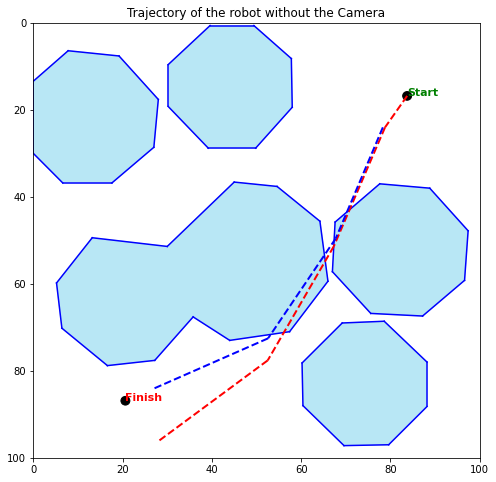

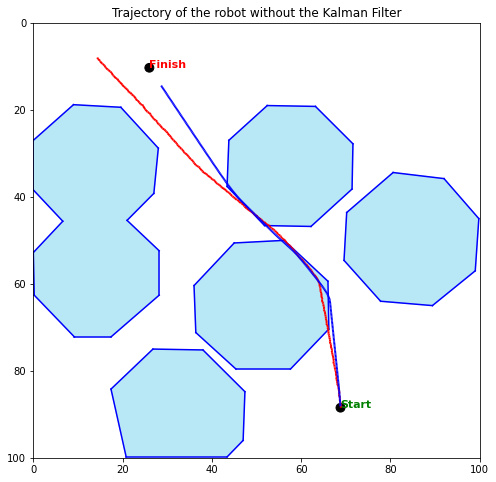

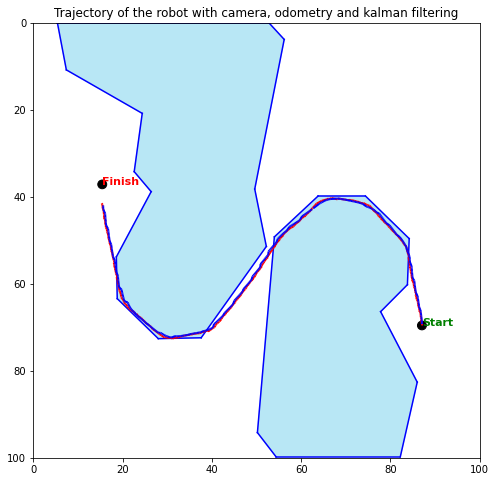

In [27]:
from Functions import Visualization as vis
import matplotlib.pyplot as plt

vs = vis.Visualization()
plt.title('Trajectory of the robot without the Camera')
vs.plotTrajectories('runs/run_13_nofilter.pkl')
plt.title('Trajectory of the robot without the Kalman Filter')
vs.plotTrajectories('runs/run_10_nocamfilter.pkl')
plt.title('Trajectory of the robot with camera, odometry and kalman filtering')
vs.plotTrajectories('runs/run_3.pkl')

One way to improve the results and reduce the dependancy of the filter on the camera, could be by adding some covariance terms in the matrice $Q$, especially between the positions and the velocities. Moreover one could certainly achieve a tighter control of the robot without the camera by adding the Accelerometer to the Kalman Filter.

## Robot control algorithm : 

The thymio has 4 states: 

* Init : in this state the thymio is at rest until the vision algorithm find it's position and an optimal path has been computed.
* Astolfi : In this state the robot will move to the goal using an astolfi controller with constant speed. 
* Turn : In this state the robot will turn on itself until it points close to the next goal.
* Local: In this state the robot get around the local obstacle. 
    
Robot state machine :



![FSMRobot.jpg](sample_pictures/FSMRobot.jpg)

# Function for the init state : 

def INIT(self,global_path, pos_init) : 
        ''' the robot stays in INIT state until it gets a global path and an initial position
        global path : give false if no global path else it gives the global path in a tuple
        pos_init: the initial position (x,y,theta)'''

    self.state = 'INIT'
    if global_path is not False :
        self.global_path = global_path
    else :
        return self.state
    if pos_init is not False :
        self.Pos = pos_init
    else : 
        return self.state
    # If a Pos and a global_path has been found enter in ASTOLFI mode
    self.node = 0
    self.state = 'ASTOLFI'
    return self.stateFSMRobot.jpg)

The thymio starts in the **Init** state, when it receive a valid global path it switches to **Astolfi**, or **turn** State. In the **Astolfi** state the values given to the motor for the left and right wheel will be computed using an astolfi closed control loop. The robot switches to state **TURN** if the angle $\alpha$ (more detail in Astolfi section) is higer than $\frac{\pi}{2}$. Once it is in state **TURN** it will perform a stationary turn until the absolute value $\alpha$ is less than $\frac{\pi}{2}$.

### INIT State:

In the **Init** State the robot will stay at rest and will stay in this state until in receive it's position by the camera and a liste of tuple with the points that forms the shortest path (calculate in the Global.py module). 

### INIT state implementation : 
``` python
def INIT(self,global_path, pos_init) : 
        ''' the robot stays in INIT state until it gets a global path and an initial position
        global path : give false if no global path else it gives the global path in a tuple
        pos_init: the initial position (x,y,theta)'''

    self.state = 'INIT'
    if global_path is not False :
        self.global_path = global_path
    else :
        return self.state
    if pos_init is not False :
        self.Pos = pos_init
    else : 
        return self.state
    # If a Pos and a global_path has been found enter in ASTOLFI mode
    self.node = 0
    self.state = 'ASTOLFI'
    return self.state
```

### ASTOLFI State : 



### Description of the parameters : 


In this state, the robot will follow the trajectory of the global path using the astolfi controller with the parameters ($\alpha$, $\beta$, $\rho$). 

The parameters are represented in the figure below :

![FSMRobot.jpg](sample_pictures/astolfidiag.jpg)

The values for $\alpha$ $\beta$ and $\rho$ are : 


$\alpha = atan2(\Delta y,\Delta x)-\theta$ in [rad]

$\rho=\sqrt{\Delta x^2+\Delta y^2}$ in [cm]

$\beta=\alpha-\theta-\beta_{ref}$ in [rad]

$\beta_{ref}$ will be computed each time the thymio reach a node of the shortest path and it's value will be equal to the angle between the x axis and the line connecting the two node of the shortest path where the thymio is. For exemple, if the thymio is between the first node and the second node of the shortest path. $\beta_{ref}$ will be equal to the angle between the x axis and the line connecting node one and node two of the global path. 

The goal for this controller will be defined as the next node of the global path. Once we are close to the goal ($\rho<5$) we assume that the thymio has arrived to this node and we recompute the goal as the next node of the global path. 
For example if we have four node in the global path : our first goal will be node 2, once we arrive close to node 2 our next goal will be node 3 and once we arrive close to node 3 our final goal will be node 4. 




### Closed loop control law  : 

We decided to apply an astolfi controller with constant linear speed (the formula is the same as seen in lecture 1 of the course, but we normalize it by rho to get constant speed): 

$v=k_{\rho}$  
    
$\omega=\frac{k_{\alpha} \alpha + k_{\beta} \beta}{\rho} $

And the closed loop system will be equal to : 
$
\begin{bmatrix}
\dot{\rho}\\ 
\dot{\alpha}\\ 
\dot{\beta}
\end{bmatrix}=\begin{bmatrix}
-k_{\rho}\\ 
(k_{\rho}\alpha-k_{\alpha}\alpha -k_{\beta}\beta)/ \rho\\ 
(-k_{\rho}sin\alpha)/\rho
\end{bmatrix}
$

(We get a singularity point for $\rho=0$. To avoid this problem we will assume that the robot arrive at destination when $\rho<3 cm$) 

A function in the module class Robot have been created to simulate the trajectory of the robot with this controller given a path and different values for parameters $\alpha$, $\beta$ and $\rho$ : 

(remarks: if during this simulation we get a two big $\alpha$, we will turn the robot on itself until alpha is close to 0, see the State TURN section for more information)

In [8]:
def astolfiDemo(kp = 3., ka = 35., kb = -8.):
    #Those Parameters can be modified to test our Controller

    ############################################################################################################



    global_path = [(10.,15.),(40.,30.),(30.,50.1)] # Point of the global path [(xstart,ystart),....,(xgoal,ygoal)]

    InitAngle=math.pi/10
    ##############################################################################################################

    # Initialise robot class
    Init_pos = np.array([global_path[0][0],global_path[0][1],InitAngle])
    Ts = 0.01


    vTOm=30.30
    wTOm=(200*180)/(80*math.pi)  

    # INIT PARAMETERS FOR THE ROBOT : 
    thym = Robot.Robot(global_path,Init_pos,Ts, kp,ka,kb,vTOm,wTOm)

    # SIMULATION OF THE ASTOLFI CONTROLLER
    thym.compute_path(Ts)


    # PLOT THE PATH : 

    Startx=global_path[0][0]
    Starty=global_path[0][1]
    Goalx=global_path[-1][0]
    Goaly=global_path[-1][1]


    plt.plot(thym.pathcontrolx, thym.pathcontroly, 'b-',label="trajectory")
    plt.plot(thym.Global_x,thym.Global_y,'ro',label="node of the shortest path")
    plt.plot(Startx,Starty,'go',markersize=15,label="Start")
    plt.plot(Goalx,Goaly,'rX',markersize=15,label="Goal")

    # Add a legend
    plt.title('thymio trajectory')

    # y axis down : 
    plt.gca().invert_yaxis()
    plt.legend()#'trajectory','node of the shortest path','Start','Goal')
    # Show the plot : 
    plt.show()
    
w = interactive(astolfiDemo,kp=(0.1,15.),ka=(10.,40.),kb=(-20.,0.) )
display(w)

interactive(children=(FloatSlider(value=3.0, description='kp', max=15.0, min=0.1), FloatSlider(value=35.0, des…

By testing different values for $k_{\rho}$, $k_{\alpha}$ and $k_{\beta}$, we decided to keep : 

$k_{\rho}=3$

$k_{\alpha}=35$

$k_{\beta}=-8$

With those parameter we ensure that the robot have a smooth trajectory and will turn close to he node of the global path so that they avoid going inside global obstacles. 

### Advantages and Limitation of the Astolfi controller:  

**Advantages**: This controller allows the robot to have a smooth trajectory

The parameters $k_{\alpha}$, $k_{\beta}$ and $k_{\rho}$ can be easily changed and it is therefore easy to adapt our controller to different situations (for exemple: to deal with the delay of the bluetooth, we diminished the the values of thoses parameters). 

**Limitation** :Making some tests on the thymio on a real map with global obstacles we observe that this controller works well. 
Nevertheless some case exist where this controller is not suitable : 

If a thymio with bluetooth is used, we have to reduce the parameters $k_{\alpha}$,$k_{\beta}$ (and $k_{\rho}$). Since we have some delay and that we use the measurement of the position and angle of the robot by the camera in our filter, we have to reduce the responsiveness to the angular error (this could lead to ondulation in the robot trajectory) 

Moreover if $\rho$ is too small and $\alpha$ is too big, we could have some large angular velocity that the thymio couldn't handle. 
To avoid this problem, we decided that the thymio move to the next goal when it's distance to the actual goal is lower than 5cm.

Moreover, this controller works when $\frac{-\pi}{2}<\alpha<\frac{\pi}{2}$. To make our robot work in every situtation we add to the thymio the state : **TURN** when $\alpha$ is not in the bound. 

### ASTOLFI state implementation : 
``` python
 def ASTOLFI(self,th,Ts,filter,pos_cam, update_cam):
        ''' Astolfi controller with constant speed is used to control the robot when the angle alpha is between -pi/2 and pi/2
             th : serial link to the thymio
             Ts : time of one iteration of the loop while (we recompute every Ts)
             filter: a kalman filter is used using the measurement of the left and right motor and the measurement of the camera
             pos_cam: measurement of the camera'''
        
        #[give : x,y,theta,vr,vl] to the filter : 
        vect = self.get_states()

        # check if we detect a local obstacle
        self.check_localobstacle(th)
        
        if self.state == 'LOCAL' :
            return self.state

        # converting x,y and theta in rho, beta and alpha (Astolfi controller)
        self.compute_pba()

        if abs(self.a)>m.pi/2:
            # calculate rho, beta and alpha at time t+1(Astolfi controller)
            self.state='TURN'
            return self.state

        #  Check for kidnapping 

        elif pos_cam is not False and pos_cam[0] != 0 and np.linalg.norm(pos_cam[0:2] - vect[0:2],2) > 10.:
            self.state = 'INIT'
            th.set_var('motor.left.target',0)
            th.set_var('motor.right.target',0)
            time.sleep(3)
            return self.state
        
        # If no kidnapping and a correct angle alpha : 

        else :
            # compute rho, alpha and beta at time t+ts
            self.compute_state_equation(Ts)
            # convert rho, beta and alpha in x y and theta (need those parameters for the filter)
            self.compute_Pos()
            # check if we are close to the next point in the global path and change the next goal in the astolfi controller if it is the case
            self.check()
            # calculate the velocity and angular velocity and the value we need to give to the left and right motor
            self.compute_input()

            # give the value of the motor to the thymio 
            self.run_on_thymio(th)

            #[give : x,y,theta,vr,vl] to the filter : 
            vect = self.get_states()

            # sleep 0.1 second :
            time.sleep(0.1)

            # get our pos with the filter
            filter.compute_kalman(pos_cam,vect,th,Ts,update_cam)
            return self.Pos
```

#### Astolfi parameters and outputed motor speed values recorded during example run

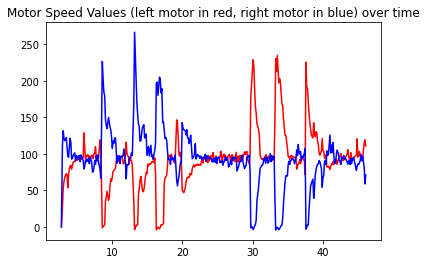

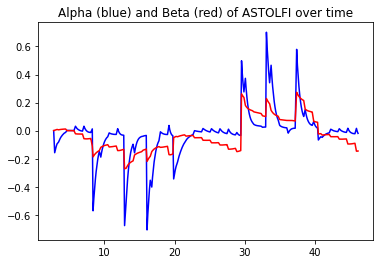

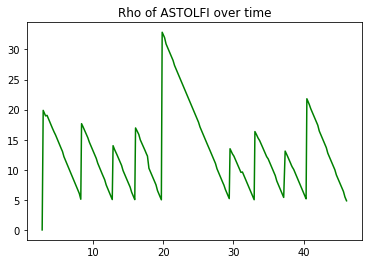

In [130]:
vz.plotAstolfi('runs/run_3.pkl')

## TURN State : 

In the **TURN** state, the robot will turn with a constant angular velocity $\omega=0.3$ and with no linear velocity. It will go back in Astolfi state when $|\alpha|<0.1$ [rad]

### TURN state implementation : 
``` python
    def TURN(self,th,Ts,filter, pos_cam, update_cam):

        '''if abs(alpha)>pi/2 we can't use astolfi and we first need to rotate the robot on itslef. We make it turn on  itself until alpha 
            is close to 0
           th : serial link to the thymio
           Ts : time of one iteration of the loop while (we recompute every Ts)'''
        

        vect = self.get_states()
        
        #  Check for kidnapping 
        if pos_cam is not False and pos_cam[0] != 0 and np.linalg.norm(pos_cam[0:2] - vect[0:2],2) > 10.:
            self.state = 'INIT'
            th.set_var('motor.left.target',0)
            th.set_var('motor.right.target',0)
            time.sleep(3)
            return self.state
        
        # estimate the new position of the robot at time t+Ts:
        
        self.compute_rotation(Ts)
        
        # calculate the angular velocity and the value we need to give to the left and right motor
        self.compute_input()

        # give the value of the motor to the thymio 
        self.run_on_thymio(th)

        # sleep 0.1 second :
        time.sleep(0.1)

        #[give : x,y,theta,vr,vl] to the filter : 
        vect = self.get_states()

        # sleep 0.1 second :
        time.sleep(0.1)

        # get our pos with the filter
        filter.compute_kalman(pos_cam,vect,th,Ts,update_cam)
```

### LOCAL State

The robot enters this state when it's horizontal sensors detects an obstacle close to it. To consider that the obstacle is close to the robot we test if the values of the different sensors are above a treshold (the threshold will be different depending on the sensor). Once it detects the obstacle it will start turning on itself in the left direction if it detects the obstacle on the right or in the right direction if it detects the obstacle on the left.

Once the thymio enter in LOCAL STATE it will switch between 3 types of displacement. Turn Left on itself, Turn right on itself and going straight. 

For the explanation we will assume that thymio found an obstacle on it's left (if the obstalce is on the right the direction of th turn will be the opposite). 

#### Turn right :

If the thymio found an obstacle on it's left it will turn right on itslef with an angular velocity equal to $\omega=0.3$ [rad/s] until it doesn't feel any obstacle on it's horizontal sensor and will start going straight.

#### Going Straigt :

It will start going staight at constant linear velocity during 2 seconds at 2cm/s (The range of the sensor are above 4 cm and we are sure that no obstacle on this distance. After 2 second it will start turning left.

#### Turning Left : 

The thymio will then turn left with an angular velocity equal to $\omega=0.3$ [rad/s] until it feels again the obstacle and will go back in the mode turning right and the loop will repeat. 

#### Getting out of the local avoidance mode : 

This loop of three displacement allow the robot to stay close the obstacle and to go aroud it. It will get out the LOCAL AVOIDANCE state if the robot is pointing toward the current goal. 




### LOCAL state implementation : 
``` python
    self.sensor= np.array(th["prox.horizontal"]) #get values from the sensors
        if self.sensor[0]>1000 or self.sensor[1]>1000 or self.sensor[2]>3000 or self.sensor[3]>1000 or self.sensor[4]>1000:
            self.state='LOCAL'
            right=self.sensor[4]+self.sensor[3]   #values of the right self.sensors   
            left=self.sensor[0]+self.sensor[1]    #values of the left self.sensors
            if right>left:              #turn right if it feels the object on the left
                self.turn=0
                self.idx_sensor=(3,4)
            else:                       #turn left if it feels the object on the right 
                self.turn=1
                self.idx_sensor=(1,0)
```

#### Checking wheter we can exit the LOCAL state or not : 
``` python
    #angle correspond to the angle between x axis and the line that link the robot and the goal 
    angle=ut.compute_angle(self.Pos[0:2],self.global_path[self.node+1])

    #test is the difference between the angle theta of the robot and angle calculate above (value in [-pi pi]) 
    test=(m.pi+self.Pos[2]-angle)%(2*m.pi)-m.pi
    if abs(test)<0.1:
        self.state='INIT'
```

#### recomputing the path when exiting the LOCAL state : 

Once the thymio detect that the obstacle has been passed. It returns in **INIT** state and a new path is recomputed. 
Since our thymio deviated from it's original trajectory due to the local obstacle, recomputing a path allow us to ensure that we still take the shortest path after the local avoidance.

#### Local avoidance replay with recorded data (note that the planned path changes when the robots exits the LOCAL state)

In [28]:
vz.replay('runs/run_1_local.pkl')

interactive(children=(IntSlider(value=30, description='time', max=401), Checkbox(value=True, description='trac…

#### Video example of local avoidance

In [29]:
Video("videos/local.mp4",width=400)

## Finish State : 

If the thymio is close to the last node of the global path (the GOAL): when $\rho<3$, the thymio will stop the motor and will announce that it arrives at it's objective, this triggers the shutdown of the program and the saving of the run history.

### Finish state implementation
```python    
    def FINISH(self,th, go) :
        '''check if we are close enough to the goal to stop'''
        if self.p is not None :
            if self.p<5 and self.node==len(self.global_path)-2:
                th.set_var("motor.left.target", 0)
                th.set_var("motor.right.target", 0)
                print('FININSH!!!!')
                go = 0
        return go

```

## Kidnapping 

If the thymio is in state **TURNIG**, **ASTOLFI** or **LOCAL** it can be kidnapped: taken and moved to another place on the map. The kidnapping will be detected thanks to the camera. If the value of the position measured on the camera is too different from the position estimation of the kalmann filter the thymio will detect that it is has been kidnapped and will go back in **INIT** state and  wait that for a new global path to be computed. 

Condition for Kidnapping : $\sqrt{(x_{measured}-x_{estimated})^2+(y_{measured}-y_{estimated})^2}>10$ [cm]

#### Kidnapping replay with recorded data

In [8]:
vz.replay('runs/run_5.pkl')

interactive(children=(IntSlider(value=30, description='time', max=385), Checkbox(value=True, description='trac…

#### Video of the run replayed above : 

In [13]:
Video("videos/kidnapped.mp4",width=400)

## Motor characterization 

In our different state we will calculate a linear velocity in [cm/s] and an angular velocity [rad/s].
Nevertheless the values given to the wheels of the motors are between -500 and +500. 

To get the relation between the linear velocity, angular velocity and values to the motors we introdce two constant : 
        
        vTOm : multiplying this constant by the linear velocity wanted will give us the value we need to give on the left and right wheel.
        wTOm : multiplying this constant by the angular velociy wanted will give us the value we need to give on the left wheel and right wheel (+ for the left wheel and - for the right wheel)
       
Introducing this value allows us to change easily the relationship between the velocity and values for the motors since those two constant differ on each thymio. 

By making many measurements we find : 

$vTOm=30.3 $

$wTOm=142  $

Exemple : If we want v=3 [cm/s] and w=0.3 [rad/s]

we will have 

$ML=v*vTOm+w*wTOm= 133.5000$

$MR=v*vTOm-w*wTOm= 48.3000 $

with ML and MR the values given respectively to the left and right motor

## Updating the robot's postion : 

we recompute the position of the thymio every 0.1 second.

To compute the new position of the robot when it turns on itself we use the following equation (in **LOCAL** or **TURN** state):

$x_{t_{k+1}}=x_{t_{k}}$

$y_{t_{k+1}}=y_{t_{k}}$

$\theta_{t_{k+1}}=\theta_{t_{k}}+\omega dt$

with dt= 0.1

To compute the new position of the robot when the robot is going straight (in **LOCAL** state) :

$x_{t_{k+1}}=x_{t_{k}}+v \times cos(\theta) dt$

$y_{t_{k+1}}=y_{t_{k}}+v \times sin(\theta) dt$

$\theta_{t_{k+1}}=\theta_{t_{k}}$

To compute the new position of the robot in state **ASTOLFI** : 

We use the second order runge Kutta equation for the discretisation: 

$x_{t_{k+1}}=x_{t_{k}}+\frac{dt}{2}*f(x_{t_{k}})+\frac{dt}{2}*f(x_{t_{k}}+dt*f(x_{t_{k}}))$  with $\dot{x}=f(x)$

In python we we use 2 function to compute the updated position : 


```python    
    #correspond to the function f (formula for f can be found above in the Astolfi section) 
    def astofli_controller(self,p,a,b):
        ''' compute the derivative of rho beta and alpha'''
        p_dot=-self.kp*m.cos(a)
        a_dot=(self.kp*m.sin(a)-self.ka*a-self.kb*b)/p
        b_dot=(-self.kp*m.sin(a))/p
        return p_dot,a_dot,b_dot

    # compute the estimation of rho beta and alpha at time t+Ts and give a value for v and w (linear and angular velocity)
    def compute_state_equation(self,Ts):
        ''' use runge Kutta 2 to get rho alpha and beta at time t+Ts '''
        [p_dot1,a_dot1,b_dot1]=self.astofli_controller(self.p,self.a,self.b)

        p1=self.p+Ts*p_dot1
        a1=self.a+Ts*a_dot1
        b1=self.b+Ts*b_dot1

        [p_dot2,a_dot2,b_dot2]=self.astofli_controller(p1,a1,b1)

        self.p=self.p+Ts/2.*p_dot1+Ts/2.*p_dot2
        self.a=self.a+Ts/2.*a_dot1+Ts/2.*a_dot2
        self.b=self.b+Ts/2.*b_dot1+Ts/2.*b_dot2

        self.u[0]=self.kp
        self.u[1]=(self.ka*self.a+self.kb*(self.b))/self.p
```

When we are in the **Astolfi** state we need to convert $\rho$ $\alpha$ and $\beta$ to values in the cartestian coordinate : (x,y,$\theta$) So that we can give those estimation of the position and angle to the Kalman filter. Moreover, the Kalman filter will gives us updated values for x y $\theta$. Therefore we need to be able to find the relation between  ($\rho$,$\alpha$,$\beta$) and (x,y,$\theta$).

Here are the formula to go from ($\rho$,$\alpha$,$\beta$) to (x,y,$\theta$) : 

$x=x_{Goal}-\rho*cos(\beta+\beta_{ref})$ [cm]

$y=y_{Goal}+\rho*sin(\beta+\beta_{ref})$ [cm]

$\theta=-\beta-\beta_{ref}-\alpha$ [rad]

those formulas are implemented in the function : compute_pos() in the class Robot

Here are the formula to go from (x,y,$\theta$) to ($\rho$,$\alpha$,$\beta$)  : 

$\alpha = atan2(\Delta y,\Delta x)-\theta$ in [rad]

$\rho=\sqrt{\Delta x^2+\Delta y^2}$ in [cm]

$\beta=\alpha-\theta-\beta_{ref}$ in [rad]

Those formulas are implemented in the function : compute_pba() in the class Robot : 

### Testbench for the module Global + Local Navigation without Vision : 

A testbench navigation has been made to test the local and global navigation without using the Vision measurements in the Kalman Filter.

In [3]:
from Functions import Robot
from Functions import Filtering
from Functions import Thymio
import os
import sys
import numpy as np
import math as m
import time

th = Thymio.Thymio.serial(port="/dev/cu.usbmodem141401", refreshing_rate=0.1) # change the port depending on the thymio 

time.sleep(3) # To make sure the Thymio has had time to connect

# GET THE GLOBAL PATH WITH THE CAMERA AND THE GLOBAL PATH CLASS : 

#choose the global path 
global_path = [(0.,0.),(500.,0.)] # You can modify the values to get an other global path

# Initialise robot class
Init_pos = np.array([global_path[0][0],global_path[0][1],0])    # to get the init pos of the robot
Ts = 0.1
kp = 1.5 #3    #0.15   #0.5
ka = 18 #35  #0.4    #0.8
kb = -4 #-8   #-0.07  #-0.2

vTOm=30.30
wTOm=(200*180)/(80*m.pi) 





thym = Robot.Robot(global_path,Init_pos,Ts, kp,ka,kb,vTOm,wTOm)



# Initialise Filtering class
Rvel = np.array([[10000, 0.], [0.,10000]])
Hvel = np.array([[0.,0.,0.,1.,0.],[0.,0.,0.,0.,1.]])
Rcam = np.array([[0.000001,0.,0.],[0.,0.000001,0.],[0.,0.,0.000001]])
Hcam = np.array([[1.,0.,0.,0.,0.],[0.,1.,0.,0.,0.],[0.,0.,1.,0.,0.]])

filter = Filtering.Filtering(Rvel, Rcam, thym, Hvel, Hcam,Ts)

thym.go=1


# Begin testbench

pos_cam=False #put to false to don't take into account the vision 
update_cam=False

while thym.go:
    tps1 = time.monotonic() #Use to count the time for one cycle will be use to measure Ts at the next iteration

    # FSM OF THE THYMIO 
    if thym.state =='ASTOLFI' : 
        thym.ASTOLFI(th,Ts, filter,pos_cam,update_cam)
    elif thym.state == 'TURN' :
        thym.TURN(th,Ts,update_cam)
    elif thym.state == 'LOCAL' :
        thym.LOCAL(th,Ts,filter,pos_cam,update_cam)
        
        # Since we give the path and the position directly and that we don't use the camera the thymio will not stay in init mode
    elif thym.state == 'INIT' :
        thym.INIT(global_path,Init_pos)
    
    tps2 = time.monotonic()
    Ts=tps2-tps1

    #print(thym.Pos)
    # check if we arrive at the goal 
    if thym.p<3 and thym.node==len(thym.global_path)-2:
        th.set_var("motor.left.target", 0)
        th.set_var("motor.right.target", 0)
        print('FININSH!!!!')
        tfinal=time.monotonic()

        thym.go=0 #get out of the while loop once we are at destination 

SerialException: [Errno 2] could not open port /dev/cu.usbmodem141401: [Errno 2] No such file or directory: '/dev/cu.usbmodem141401'

## Running the complete control algorithm :

The control algorithm is mean to be run by running the file *main.py*, it can take the following arguments :
* v to run in verbose mode
* w to load a test image instead of using the webcam
* r to run without a robot to test vision
* f to save the run as a .pkl file

The robot's address port and the webcam can be selected modifying *main.py* (lines 481 *robotPort = "/dev/cu.usbmodem141101"* and 162, *cv2.VideoCapture(0)* ), warning on windows the prompt print will print a lot of data, it is not the case on posix systems, so this program runs nicer on macos or linux, but will still run on windows, the command line display will just be less clean.

## Conclusion

In conclusion we find that our project achieves its goals it successfully navigates the environnement we defined for it. It doesn't collide with ostacles and manages to implement global navigation quite accurately while still being able to perform local obstacle avoidance.

However as shown in the previous sections there are some limitations, due to some approximations, assumptions and also generally to the limited scope of the project. The local avoidance is not able to avoid global obstacle. Another limitation is the rather crude approach taken to the vision, color filtering makes the vision quite sensitive to changes in the environnement.

Nevertheless our project is modular, can react to changes in its environnement, can deal with kidnapping and generally is quite robust. Our codebase is suffiently clean so that we could easily replace one component or another either to improve performance, to port it to different hardware to replace whatever component we want to test out different approaches.

## Appendix 1 : Interactive viewer of data log of testing runs for 13 different runs with kidnapping, local avoidance and no camera/no filter tests

In [6]:
runs = ['runs/run_1_local.pkl',
        'runs/run_2.pkl',
        'runs/run_3.pkl',
        'runs/run_4.pkl',
        'runs/run_5.pkl',
        'runs/run_6.pkl',
        'runs/run_7.pkl',
        'runs/run_8.pkl',
        'runs/run_9.pkl',
        'runs/run_10_nocamfilter.pkl',
        'runs/run_11.pkl',
        'runs/run_12.pkl',
        'runs/run_13_nofilter.pkl',]
plots = ['trace',
         'ASTOLFI',
         'sensor']
w = interactive(vz.metaPlotter,data=runs,plotType=plots)
display(w)

interactive(children=(Dropdown(description='data', options=('runs/run_1_local.pkl', 'runs/run_2.pkl', 'runs/ru…

## Appendix 2 : vTOm and wTOm estimation

In order to have a better model of the real velocity of the wheels when we give an input to the motor we performed measures to obtain a linear regression of the datas. To do so we used the method shown in the Lab 8 of the course to estimate the velocity of the robot by measuring the time it took it to cross several white strips which are detected by the ground sensor. It gave the following results : 

<center><img src ='sample_pictures/vTOm.JPG' width = 400>

Since the speed of the robot must be zero for a zero input we decided to not take into account the Offset. This approximation doesn't seems to bad since the higher the velocity is, the higher the standard deviation seems to be, hence the extreme values should be discarded. Hence the linear regression becomes :

<center><img src ='sample_pictures/vTOm2.JPG' width = 400>

By taking the value of $a$ one can now find the appropriate input to give to the motor to reach the desired speed in cm/s. The exact same method is used to estimate wTOm and a value of 130